# Lab2 - Complessità Definizionale 

**Obiettivo**: Studio pratico della complessità nella formulazione di definizioni attraverso l'analisi dell'overlap lessicale e semantico tra definizioni di concetti generici/specifici e concreti/astratti.

## Introduzione

Questo laboratorio esplora la **complessità definizionale** confrontando definizioni di concetti con proprietà diverse:

- **Concretezza**: concetti generico (Pantalone) vs specifico (Microscopio)
- **Astrattezza**: concetti generico (Pericolo) vs specifico (Euristica)


In [ ]:
# Import librerie e setup ambiente
from importlib import reload
from pathlib import Path
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Import moduli locali
from src import lab2_utils
from src.utils import get_spacy_en_modelname, ensure_dir

reload(lab2_utils)

# Configurazione
warnings.filterwarnings('ignore')
random.seed(42)
np.random.seed(42)

# Stile grafici
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Percorsi
DATA_DIR = Path('data')
OUTPUT_DIR = Path('outputs')
ensure_dir('outputs')
ensure_dir('outputs/visualizations')

# Download risorse NLTK
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("Risorse NLTK scaricate")

# Caricamento modello spaCy per italiano
import spacy

try:
    model_name = get_spacy_en_modelname()
    nlp = spacy.load(model_name)
    print(f"Modello spaCy '{model_name}' caricato")
except OSError:
    print("⚠️ Modello spaCy non trovato. lancia lo script di installazione:")
    nlp = None

print("Setup completato!")

Risorse NLTK scaricate
Detected CUDA version: 12.3
Modello spaCy 'it_core_news_sm' caricato
Setup completato!


## Dataset

### Raccolta dati collettiva

La prima fase è stato un lavor collettivo per raccogliere definizioni dei vari concetti.


In [2]:
# Caricamento dataset
raw_df = pd.read_csv(DATA_DIR / 'dataset_definizioni_Lab2.csv', sep=';')
words = list(raw_df.columns)

print(f"Dataset caricato: {raw_df.shape[0]} righe × {raw_df.shape[1]} colonne")
print(f"\nColonne: {words}")
raw_df.head()

Dataset caricato: 38 righe × 4 colonne

Colonne: ['Pantalone', 'Microscopio', 'Pericolo', 'Euristica']


,Pantalone,Microscopio,Pericolo,Euristica
0,Indumento che si indossa sulla parte inferiore...,Strumento scientifico atto a osservare il mond...,Situazione o Evento che può mettere a rischio ...,Metodo matematico e statistico per risolvere u...
1,Indumento per la parte inferiore del corpo umano,Strumento scientifico per l'osservazione di mi...,Situazione potenzialmente rischiosa,Strategia di ricerca nello spazio degli stati
2,"Indumento per le gambe, diviso per ogni gamba ...",Dispositivo ottico o elettronico per ispeziona...,Situazione in cui si teme per la propria o alt...,Strategia di ricerca che permette di stimare i...
3,abito indossato sulle gambe,strumento dotato di lenti che permette di visu...,condizione che può causare danni alle persone ...,regola che permette di approssimare una soluzi...
4,capo di abbigliamento per le gambe,strumento per osservare da vicino cose molto p...,Evento che minaccia la sicurezza di una persona,"La metodologia di ricerca di fatti o verità, o..."


### TODO: Analisi e riflessione sui risultati

Sulla base dei risultati ottenuti, provate a rispondere alle seguenti domande:

- le scelte linguistiche adottate;
- il grado di specificità;
- le difficoltà incontrate nel definire concetti astratti rispetto a quelli concreti;
- l’uso (o assenza) di strategie definitorie canoniche.

## Preprocessing

Normalizzazione delle definizioni:
1. Lowercasing
2. Rimozione punteggiatura
3. Tokenizzazione
4. Stopword removal (italiano)
5. Lemmatizzazione con spaCy

In [3]:
print("Preprocessing in corso...")

# Trasforma il dataset wide in formato long
df = (
    raw_df.melt(var_name="concept", value_name="definition")
    .dropna()
    .reset_index(drop=True)
)

df["definition_id"] = df.groupby("concept").cumcount() + 1

# Metadati dei concetti (concretezza e specificità)
# Utile per analisi successive con aggregati dei risultati
concept_meta = {
    "Pantalone": {"concreteness": "concreto", "specificity": "generico"},
    "Microscopio": {"concreteness": "concreto", "specificity": "specifico"},
    "Pericolo": {"concreteness": "astratto", "specificity": "generico"},
    "Euristica": {"concreteness": "astratto", "specificity": "specifico"},
}

df["concreteness"] = df["concept"].map(
    {k: v["concreteness"] for k, v in concept_meta.items()}
).fillna("n/a")
df["specificity"] = df["concept"].map(
    {k: v["specificity"] for k, v in concept_meta.items()}
).fillna("n/a")

# Preprocessing delle definizioni
df["tokens"] = df["definition"].astype(str).apply(
    lambda text: lab2_utils.preprocess_definition(text, nlp)
)
df["n_tokens"] = df["tokens"].apply(len)

# Dizionario: concetto -> lista di definizioni preprocessate
definitions_by_concept = {
    concept: df.loc[df["concept"] == concept, "tokens"].tolist()
    for concept in df["concept"].unique()
}

display(df)
print("Preprocessing completato!")
print(f"Definizioni totali: {len(df)}")
print(f"Concetti: {list(definitions_by_concept.keys())}")

Preprocessing in corso...


,concept,definition,definition_id,concreteness,specificity,tokens,n_tokens
0,Pantalone,Indumento che si indossa sulla parte inferiore...,1,concreto,generico,"[indumento, indossare, su il, parte, inferiore...",11
1,Pantalone,Indumento per la parte inferiore del corpo umano,2,concreto,generico,"[indumento, parte, inferiore, di il, corpo, um...",6
2,Pantalone,"Indumento per le gambe, diviso per ogni gamba ...",3,concreto,generico,"[indumento, gamba, dividere, ogni, gamba, pote...",11
3,Pantalone,abito indossato sulle gambe,4,concreto,generico,"[abitare, indossare, su il, gamba]",4
4,Pantalone,capo di abbigliamento per le gambe,5,concreto,generico,"[capo, abbigliamento, gamba]",3
...,...,...,...,...,...,...,...
147,Euristica,approssimazione fatta rispetto a un insieme di...,34,astratto,specifico,"[Approssimazione, fare, rispetto, insieme, str...",11
148,Euristica,funzione che permette di calcolare un risultat...,35,astratto,specifico,"[funzione, permettere, calcolare, risultato, d...",8
149,Euristica,un insieme di metodi di ricerca che facilitano...,36,astratto,specifico,"[insieme, metodo, ricerca, facilitare, scopert...",9
150,Euristica,strategia o procedimento per ricercare element...,37,astratto,specifico,"[strategia, procedimento, ricercare, elemento,...",8


Preprocessing completato!
Definizioni totali: 152
Concetti: ['Pantalone', 'Microscopio', 'Pericolo', 'Euristica']


## A. Similarità lessicale (simlex)

Calcolo della sovrapposizione lessicale tra coppie di definizioni usando **cosine similarity** su frequenze dei termini.

In [4]:
from src.utils import print_code
print_code(lab2_utils.compute_lexical_similarity)

def compute_lexical_similarity(tokens1: List[str], tokens2: List[str]) -> float:
    if len(tokens1) == 0 or len(tokens2) == 0:
        return 0.0
    freq1 = Counter(tokens1)
    freq2 = Counter(tokens2)
    all_terms = set(freq1.keys()) | set(freq2.keys())
    vec1 = np.array([freq1.get(term, 0) for term in all_terms])
    vec2 = np.array([freq2.get(term, 0) for term in all_terms])
    return cosine_similarity(vec1, vec2)


In [5]:
print("Calcolo similarità lessicale (cosine su frequenze termini)...")

simlex_matrix = lab2_utils.build_similarity_matrix(
    df['tokens'].tolist(),
    lab2_utils.compute_lexical_similarity
)

simlex_stats = lab2_utils.compute_concept_stats(simlex_matrix, df)

print(f"Matrice simlex: {simlex_matrix.shape}")
print(f"Media della media: {simlex_stats['media'].mean():.3f}")
print(f"Media della mediana: {simlex_stats['mediana'].mean():.3f}")
print(f"Media della moda: {simlex_stats['moda'].mean():.3f}")

Calcolo similarità lessicale (cosine su frequenze termini)...
Matrice simlex: (152, 152)
Media della media: 0.188
Media della mediana: 0.232
Media della moda: 0.200


## B. Similarità semantica (simsem)

Calcolo della similarità semantica usando **word embeddings**.

Metodo:
1. Rappresentare ogni definizione come media degli embedding dei suoi token
2. Calcolare cosine similarity tra i vettori medi

In [6]:
# Caricamento modello di embeddings
# Strategia: 
# 1. Tenta modello multilingue fasttext
import gensim.downloader as api

try:
    print("Caricamento modello multilingue fasttext-wiki-news-subwords-300...")
    embeddings_model = api.load('fasttext-wiki-news-subwords-300')
    print("✓ Modello multilingue caricato (supporta italiano con copertura limitata)")
except Exception as e:
    print(f"✗ Errore caricamento modello multilingue: {e}")
    raise

print(f"\nModello pronto: {embeddings_model.__class__.__name__}")
print(f"Dimensionalità: {embeddings_model.vector_size if hasattr(embeddings_model, 'vector_size') else 'N/A'}")
print(f"Vocabolario: {len(embeddings_model):,} vettori")

Caricamento modello multilingue fasttext-wiki-news-subwords-300...
✓ Modello multilingue caricato (supporta italiano con copertura limitata)

Modello pronto: KeyedVectors
Dimensionalità: 300
Vocabolario: 999,999 vettori


In [19]:
print("Calcolo similarità semantica (embeddings)...")
reload(lab2_utils)
simsem_matrix = lab2_utils.build_similarity_matrix(
    df['tokens'].tolist(),
    lab2_utils.compute_semantic_similarity,
    embeddings_model=embeddings_model
)

# Statistiche per concetto (media, mediana, moda)
simsem_stats = lab2_utils.compute_concept_stats(simsem_matrix, df)

print(f"Matrice simsem: {simsem_matrix.shape}")
print(f"Media della media: {simsem_stats['media'].mean():.3f}")
print(f"Media della mediana: {simsem_stats['mediana'].mean():.3f}")
print(f"Media della moda: {simsem_stats['moda'].mean():.3f}")

Calcolo similarità semantica (embeddings)...
Matrice simsem: (152, 152)
Media della media: 0.867
Media della mediana: 0.897
Media della moda: 0.925


In [8]:
# Tabella riassuntiva unita per simlex e simsem
summary_df = (
    simlex_stats[['concetto', 'media', 'mediana', 'moda']].rename(columns={
        'media': 'simlex_media',
        'mediana': 'simlex_mediana',
        'moda': 'simlex_moda',
    })
    .merge(
        simsem_stats[['concetto', 'media', 'mediana', 'moda']].rename(columns={
            'media': 'simsem_media',
            'mediana': 'simsem_mediana',
            'moda': 'simsem_moda',
        }),
        on='concetto',
        how='outer'
    )
)
summary_df = summary_df.sort_values('concetto').reset_index(drop=True)

display(summary_df)

,concetto,simlex_media,simlex_mediana,simlex_moda,simsem_media,simsem_mediana,simsem_moda
0,Euristica,0.059633,0.149071,0.154,0.871820,0.881951,0.870
1,Microscopio,0.235733,0.246183,0.154,0.923381,0.929452,0.936
2,Pantalone,0.272610,0.308607,0.289,0.825141,0.879152,1.000
3,Pericolo,0.185474,0.223607,0.204,0.849546,0.897843,0.896


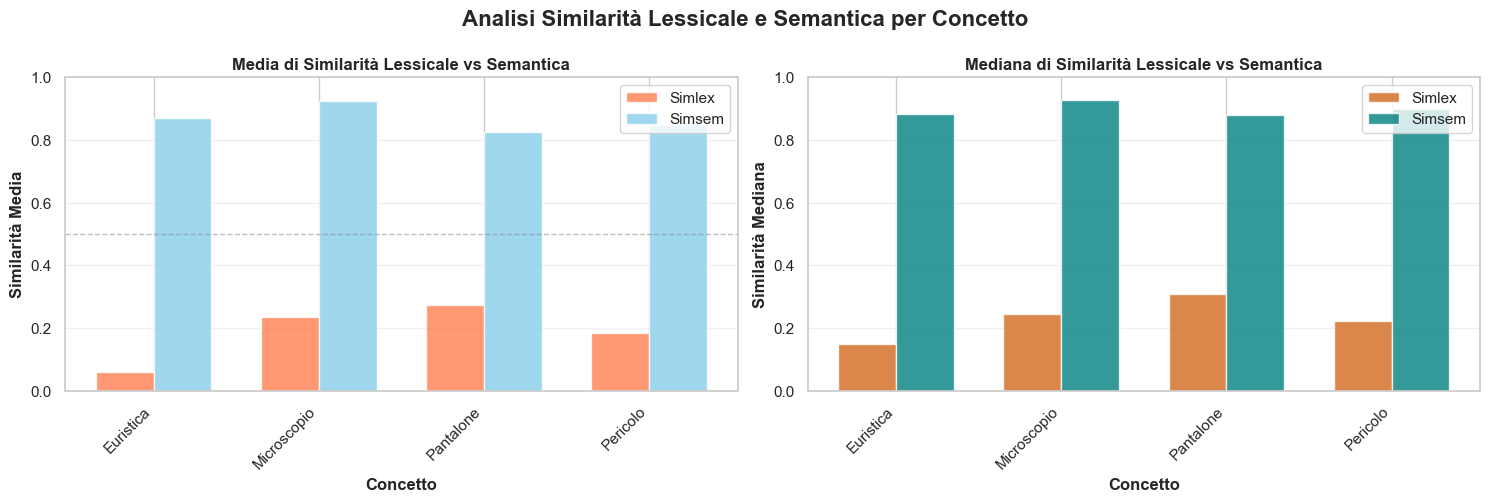

In [ ]:
# Visualizzazioni dei risultati summary_df

plt = lab2_utils.lab2_plot_summary_df(summary_df)
plt.tight_layout()
plt.show()

## Aggregazione per categoria

Calcolo delle statistiche aggregate per:
- Concretezza (concreto vs astratto)
- Specificità (generico vs specifico)

In [ ]:
# Tabella aggregata: Specificità × Concretezza
from IPython.display import HTML, display

print("=== Tabella Aggregata: Specificità × Concretezza ===\n")
agr_df, display_df = lab2_utils.lab2_table_aggregate(summary_df)

display(HTML(display_df.to_html(escape=False)))

=== Tabella Aggregata: Specificità × Concretezza ===



,Astratto,Concreto
Generico,Pericolosimlex: 0.185simsem: 0.850,Pantalonesimlex: 0.273simsem: 0.825
Specifico,Euristicasimlex: 0.060simsem: 0.872,Microscopiosimlex: 0.236simsem: 0.923


=== Generazione heatmap simlex / simsem ===


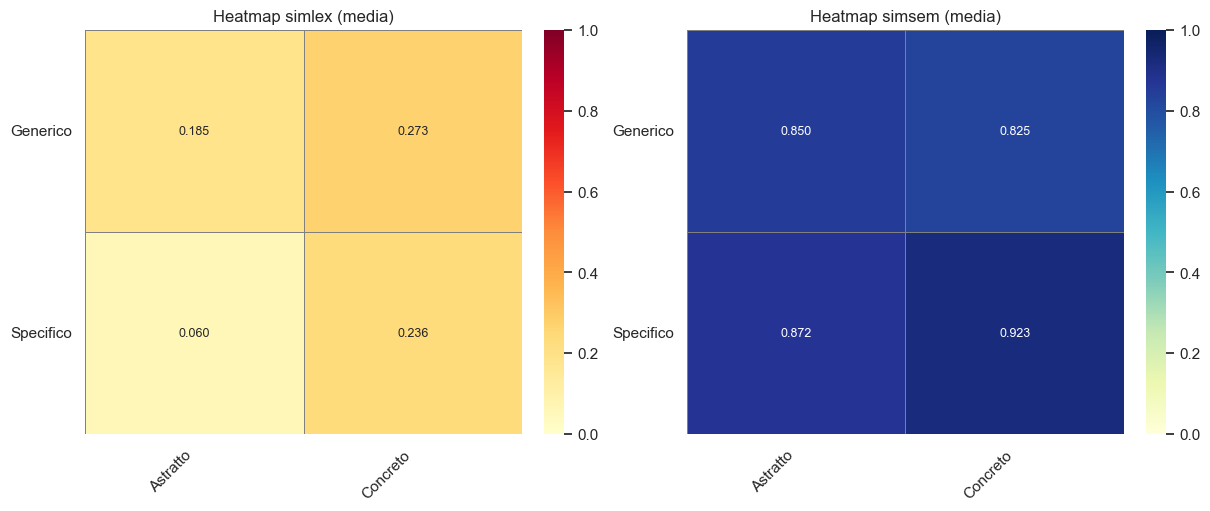

In [ ]:
# Heatmap per `agr_df` — creo due heatmap: simlex e simsem, salvo immagini e CSV
print("=== Generazione heatmap simlex / simsem ===")
fig= lab2_utils.lab2_plot_heatmap(sns, agr_df)
display(fig)
plt.close(fig)

## Conclusioni

### Sintesi dei risultati

L'analisi della complessità definizionale sui quattro concetti selezionati ha evidenziato pattern interessanti riguardo alla relazione tra natura del concetto e variabilità delle definizioni. Limitandoci a soli quattro concetti, possiamo trarre solo alcune osservazioni preliminari, che sembrano seguire quelle che sono delle teorie più accreditate.

Sul fronte lessicale, era abbastanza aspettato ottenere valori molto bassi.
I risultati mostrano una netta differenza tra concetti concreti e astratti:
- **Pantalone** (concreto generico) presenta la sovrapposizione lessicale più alta (media: 0.273), suggerendo che definizioni di oggetti concreti comuni condividono maggiormente termini specifici
- **Microscopio** (concreto specifico) raggiunge 0.236 di media, valore inferiore a Pantalone nonostante la maggiore specificità del concetto
- I concetti astratti mostrano valori più bassi: **Pericolo** (0.185) e **Euristica** (0.060), confermando la maggiore variabilità lessicale nelle loro definizioni

La bassa similarità lessicale di Euristica (0.060) indica che le definizioni di concetti astratti e tecnici utilizzano strategie linguistiche molto diverse, probabilmente alternando descrizioni funzionali, esempi e parafrasi senza convergere su un nucleo terminologico condiviso.

Il quadro cambia drasticamente considerando le similitudini semantiche:
- Tutti i concetti mostrano valori molto elevati (0.825-0.923), indicando che nonostante la bassa sovrapposizione lessicale, le definizioni mantengono coerenza semantica
- **Microscopio** ottiene il punteggio più alto (0.923), seguono **Euristica** (0.872), **Pericolo** (0.850) e **Pantalone** (0.825)
- *La discrepanza tra simlex e simsem è massima per Euristica (gap di 0.812), minima per Pantalone (gap di 0.552)*

Da qui si può quindi brevemente concludere che:
1. I concetti concreti generici (Pantalone) tendono a essere definiti con maggiore uniformità lessicale, probabilmente per la presenza di caratteristiche visive condivise facilmente descrivibili
2. I concetti astratti, seppur con bassa sovrapposizione lessicale, mantengono alta coerenza semantica: i definitori utilizzano sinonimi, parafrasi e costruzioni diverse ma convergono sullo stesso nucleo concettuale
3. La specificità non sembra correlare direttamente con la similarità: Microscopio (specifico) ha simlex più alta di Pericolo (generico), ma Euristica (specifico) ha la simlex più bassa di tutti

